In [915]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [916]:
pd.set_option("display.max_columns", None)

InteractiveShell.ast_node_interactivity = "all"

plt.figure(figsize=(14,8))

<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

In [917]:
dfPolicyData = pd.read_csv("PolicyData.csv", delimiter = ";", encoding='latin-1')
dfPolicyData.set_index("policy_guid", inplace = True)

dfInvoiceData = pd.read_csv("InvoiceData.csv", delimiter = ";")
dfInvoiceData.set_index("invoice_guid", inplace = True)


In [918]:
# They are converted from object to float
dfInvoiceData["amount_premium"] = dfInvoiceData["amount_premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')
dfPolicyData["Premium"] = dfPolicyData["Premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')

In [919]:
# 1: Invoice is paid late
# 0: Invoice is not paid late
aLabels = [1, 0]
aConditions = [
    (dfInvoiceData["due_date"] < dfInvoiceData["paid_date"]),
    (dfInvoiceData["due_date"] >= dfInvoiceData["paid_date"])
]

dfInvoiceData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [920]:
# In the dataset not all policies are ended. It s a snapshot probably around June 2018.
# There could be 3 status of policies: "Ended on time", "Terminated" and "Ongoing"
# We can build model not based on policy status, but based on number of issued invoices.

oInvocieGroupByPolicy = dfInvoiceData[["policy_guid", "is_it_paid_late"]].groupby(["policy_guid"])

dfInvoiceIssueStatistics = oInvocieGroupByPolicy.agg(["count", "sum"])

dfInvoiceIssueStatistics = dfInvoiceIssueStatistics["is_it_paid_late"] 

dfInvoiceIssueStatistics.columns = ["number_of_invoices", "number_of_late_payments"]

dfInvoiceIssueStatistics["late_payment_ratio"] = dfInvoiceIssueStatistics["number_of_late_payments"]/dfInvoiceIssueStatistics["number_of_invoices"]


dfModelData = dfPolicyData.join(dfInvoiceIssueStatistics)

In [921]:
# 1: Policy is paid late at least once
# 0: Policy is never paid late
aLabels = [1, 0]
aConditions = [
    (dfModelData["number_of_late_payments"] >= 1),
    (dfModelData["number_of_late_payments"] == 0)
]

dfModelData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [922]:
# 1: Policy is still active
# 0: Policy is ended or terminated
dfModelData["is_policy_active"] = 0

dfModelData.loc[(dfModelData["number_of_invoices"] < dfModelData["Nb_of_payments"]) & (dfModelData["Terminated"] == 0), "is_policy_active"] = 1


In [923]:
# Columns that are NaN or 'Missing' in policy dataset

dfPolicyData.columns[dfPolicyData.isna().any()].tolist()

dfMissing = dfPolicyData.astype(str) == "Missing"
dfPolicyData.columns[dfMissing.any()].tolist()


['Deductible_general', 'ClientBirthday', 'BMClassMOD', 'avgFuelConsumption']

['Region', 'FuelType', 'DriveTrain']

In [924]:
# Columns that are NaN or 'Missing' in invoice dataset.
# There is no missing data invoice dataset. 

dfInvoiceData.columns[dfInvoiceData.isna().any()].tolist()

dfMissing = dfInvoiceData.astype(str) == "Missing"
dfInvoiceData.columns[dfMissing.any()].tolist()

[]

[]

In [925]:
# There are policies where number of invoices are greater than number of issued invoices.
dfToQuestion = dfModelData[dfModelData["number_of_invoices"] > dfModelData["Nb_of_payments"]].loc[:, ["number_of_invoices", "Nb_of_payments"]]

MISSING DATA MANUPULATIONS

Deductible_general:

There are only 2 rows where Deductible_general is missing. 

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [926]:
dfMissingDecutibleGeneral = dfModelData[dfModelData["Deductible_general"].isna()]
dfModelData.drop(dfMissingDecutibleGeneral.index, inplace = True)

ClientBirthday:
    
There are only 43 rows where ClientBirthday is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [927]:
dfMissingClientBirthday = dfModelData[dfModelData["ClientBirthday"].isna()]
dfModelData.drop(dfMissingClientBirthday.index, inplace = True)

BMClassMOD:

There are only 14 rows where BMClassMOD is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [928]:
dfMissingBmClassMod = dfModelData[dfModelData["BMClassMOD"].isna()]
dfModelData.drop(dfMissingBmClassMod.index, inplace = True)

avgFuelConsumption:

There are 27927 rows where avgFuelConsumption is missing.

Since it s a big amount of rows, correlation between avgFuelConsumption and other fields are calculated for non-missing data.

It is found out that avgFuelConsumption has fair linear correlation with the attributes of Power, Weight,  VehicleFirstRegistrationYear and Premium.

Missing data is filled based on random forest classifier model since avgFuelConsumption field contains cardinal-categorical data.

RandomForestClassifier()

RMSE:  0.06962210921728557
R2:  0.6773552877292002
Accuracy:  0.8766808789767137
Recall:  0.8766808789767137
Precision:  0.9282861607918041
F1-Score:  0.9017458041663152


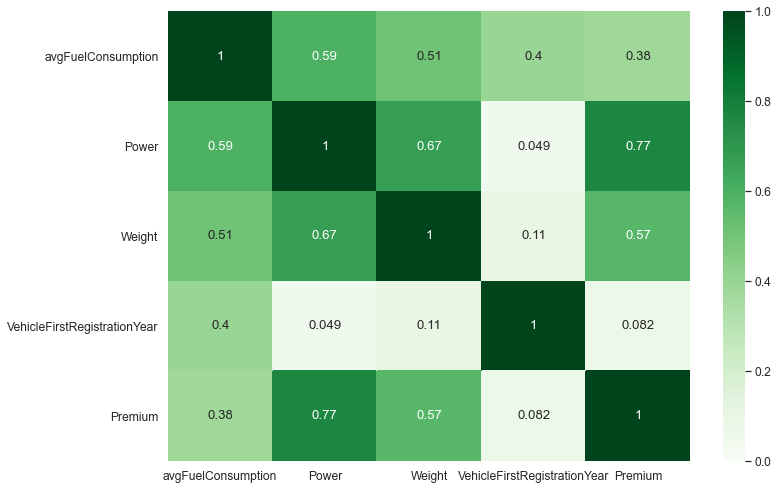

In [929]:
dfMissingAvgFuelConsumption = dfModelData[dfModelData["avgFuelConsumption"].isna()]
dfNonMissingAvgFuelConsumption = dfModelData.drop(dfMissingAvgFuelConsumption.index, inplace = False)

aUniqueAvgFuelConsumption = dfNonMissingAvgFuelConsumption["avgFuelConsumption"].unique()


dfAvgFuelConsumptionClassified = pd.get_dummies(dfNonMissingAvgFuelConsumption["avgFuelConsumption"])
dfNonMissingAvgFuelConsumption[aUniqueAvgFuelConsumption] = dfAvgFuelConsumptionClassified

dfCorr = dfNonMissingAvgFuelConsumption[["avgFuelConsumption", "Power", "Weight", "VehicleFirstRegistrationYear", "Premium"]].corr()

sns.heatmap(dfCorr.abs(), vmin=0, vmax=1, annot = True, cmap="Greens")

dfX = dfNonMissingAvgFuelConsumption[["Power", "Weight", "VehicleFirstRegistrationYear", "Premium"]]
dfY = dfNonMissingAvgFuelConsumption[aUniqueAvgFuelConsumption]

X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.3, random_state=1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

oRandForModel = RandomForestClassifier()
oRandForModel.fit(X_train, y_train)

y_pred = oRandForModel.predict(X_test)

print('RMSE: ', metrics.mean_squared_error(y_test, y_pred, squared = False))

print('R2: ', metrics.r2_score(y_test, y_pred))

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

print('Recall: ', metrics.recall_score(y_test, y_pred,zero_division=0,  average = 'micro'))

print('Precision: ', metrics.precision_score(y_test, y_pred,zero_division=0,  average = 'micro'))

print('F1-Score: ', metrics.f1_score(y_test, y_pred,zero_division=0,  average = 'micro'))

aPredictedClassesForMissing = oRandForModel.predict(dfMissingAvgFuelConsumption[["Power", "Weight", "VehicleFirstRegistrationYear", "Premium"]])

dfPredictedClassesForMissing = pd.DataFrame(data = aPredictedClassesForMissing ,  columns = aUniqueAvgFuelConsumption, index = dfMissingAvgFuelConsumption.index )

sPredictedLabels = dfPredictedClassesForMissing.idxmax(axis=1)

dfModelData["avgFuelConsumption"].fillna(sPredictedLabels, inplace = True)

In [930]:
dfModelData["Region"] = dfModelData["Region"].astype(str).apply(
    lambda x: x.replace('Missing','Missing_Region'), )

aUniqueRegions = dfModelData["Region"].unique()

dfRegionsClassified = pd.get_dummies(dfModelData["Region"])

dfModelData[aUniqueRegions] = dfRegionsClassified


In [931]:
dfModelData["FuelType"] = dfModelData["FuelType"].astype(str).apply(
    lambda x: x.replace('Missing','Missing_FuelType'), )

aUniqueFuelTypes = dfModelData["FuelType"].unique()

dfFuelTypesClassified = pd.get_dummies(dfModelData["FuelType"])
dfModelData[aUniqueFuelTypes] = dfFuelTypesClassified


In [932]:
dfModelData["DriveTrain"] = dfModelData["DriveTrain"].astype(str).apply(
    lambda x: x.replace('Missing','Missing_DriveTrain'), )

aUniqueDriveTrains = dfModelData["DriveTrain"].unique()

dfDriveTrainsClassified = pd.get_dummies(dfModelData["DriveTrain"])
dfModelData[aUniqueDriveTrains] = dfDriveTrainsClassified
